#**Detecting Fake Reviews**

This dataset is the product of research by a few folks in Computer Science: https://aclanthology.org/N13-1053.pdf. There is even a consumer-facing tool based on the model, here: http://reviewskeptic.com/. 

In [1]:
import tensorflow as tf
from tensorflow import keras
from google.colab import files
import pandas as pd
import io

trip_advisor = pd.read_csv('https://raw.githubusercontent.com/gburtch/BA865-2022/main/Week%203/datasets/deceptive-opinion.csv')

#uploaded = files.upload()
#trip_advisor = pd.read_csv(io.BytesIO(uploaded['deceptive-opinion.csv']))
trip_advisor.describe(include='all')

,deceptive,hotel,polarity,source,text
count,1600,1600,1600,1600,1600
unique,2,20,2,3,1596
top,truthful,homewood,negative,MTurk,Very disappointed in our stay in Chicago Monoc...
freq,800,80,800,800,2


We can use some of the Keras utilities to pre-process the text. 

*Q: What features should we use for our prediction?*

In [4]:
import numpy as np
from keras.preprocessing.text import text_to_word_sequence

# The dataset is perfectly balanced, so 50% accuracy will be equivalent to a random guess. 
labels = np.where(trip_advisor['deceptive']=='truthful',0,1)

text = []
for i in range(len(trip_advisor)):
  text.append(text_to_word_sequence(trip_advisor['text'][i])) # This strips punctuation, odd characters, and makes things lower-case. 

This is another pre-processing step, but it's optional. 

*Q: What does this code block do?*

In [3]:
min_freq = 1

word_freq = {}
for review in text:
  for term in review:
    try:
        word_freq[term] = word_freq[term]+1
    except KeyError:
        word_freq[term] = 1

max_freq = max(i for i in word_freq.values())
for i in range(len(text)):
  text[i] = [term for term in text[i] if word_freq[term] >= min_freq & word_freq[term] <= max_freq]

Here, we are making our integer codings for the text tokens.

In [5]:
# We declare a set, which we populate from terms from the corpus, one by one. 
# Sets only allow 'unique' values. 
unique_terms = {term for review in text for term in review}
print(f'We have {len(unique_terms)} unique tokens in our dataset.')

# We can then easily make a term-integer dictionary and an integer-term dictionary (for reverse lookup)
word_index = {term: number for number, term in enumerate(unique_terms)}
reverse_index = {number: term for number, term in enumerate(unique_terms)}

We have 10275 unique tokens in our dataset.


One-hot encoding the text can be done very explicitly now, as a nested loop.

In [6]:
def vectorize_sequences(sequences, dimension=len(unique_terms)): 
    # Make our blank matrix of 0's to store hot encodings.
    results = np.zeros((len(sequences), dimension))

    # For each observation and element in that observation,
    # Update the blank matrix to a 1 at row obs, column element value.
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, word_index[j]] = 1.
    return results

text_onehot = vectorize_sequences(text)

text_onehot.shape

(1600, 10275)

Don't forget we have a few other features in the data. It's not just about the review text... 

In [7]:
# One hot encoding the hotels. 
hotel_dict = {hotel : index for index, hotel in enumerate(set(trip_advisor['hotel']))}
hotels = []
for hotel in trip_advisor['hotel']:
  hotels.append(hotel_dict[hotel])

hotels_onehot = keras.utils.to_categorical(np.array(hotels))

# One hot encoding the review source
source_int = np.where(np.array(trip_advisor['source'])=='MTurk',0,np.where(np.array(trip_advisor['source'])=='TripAdvisor',1,2))
source_onehot = keras.utils.to_categorical(source_int)

# Binarizing the polarity
polarity_bin = np.where(np.array(trip_advisor['polarity'])=="negative",0,1).reshape(1600,1)

# Last step, we shuffle the data
data_onehot = np.concatenate((labels.reshape(1600,1),text_onehot,hotels_onehot,polarity_bin),axis=1)
np.random.shuffle(data_onehot)

# Then we pull out predictors and labels.
predictors = data_onehot[:,1:]
labels = data_onehot[:,0]


Now we can fit out model to the resulting data. Once again we have k-fold cross validation here. This model is incapable of learning anything much (validation accuracy never really surpasses 55-56%, and the loss is always increasing in training).

In [8]:
from tensorflow.keras import layers
import matplotlib.pyplot as plt

def build_model():
    model = keras.Sequential([
        # This is essentially a dense layer that mimics word embedding; we are reducing the one-hot encoded text (10,000+ one-hot tokens) down to 750 latent dimensions.
        layers.Dense(750, activation="linear"),
        layers.Dense(50, activation="relu",kernel_regularizer="l2"),
        layers.Dense(5, activation="relu"),
        layers.Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer=keras.optimizers.Adadelta(learning_rate=0.01), loss="binary_crossentropy", metrics=[keras.metrics.BinaryAccuracy(threshold=0.5)])
    return model

model = build_model()

data_train = predictors[:1200]
labels_train = labels[:1200]
data_test = predictors[1200:]
labels_test = labels[1200:]

k = 4
num_validation_samples = len(data_train) // k
num_epochs = 50
batch_sizes = 25
all_loss_histories = []
all_val_loss_histories = []  
all_acc_histories = []
all_val_acc_histories = []

# For each validation fold, we will train a full set of epochs, and store the history. 
for fold in range(k):
    validation_data = data_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    validation_targets = labels_train[num_validation_samples * fold:
                           num_validation_samples * (fold + 1)]
    training_data = np.concatenate([
        data_train[:num_validation_samples * fold],
        data_train[num_validation_samples * (fold + 1):]])
    training_targets = np.concatenate([
        labels_train[:num_validation_samples * fold],
        labels_train[num_validation_samples * (fold + 1):]])
    model = build_model()
    history = model.fit(training_data, training_targets, 
                        validation_data = (validation_data,validation_targets), 
                        epochs=num_epochs, batch_size=batch_sizes)
    val_loss_history = history.history['val_loss']
    val_acc_history = history.history['val_binary_accuracy']
    loss_history = history.history['loss']
    acc_history = history.history['binary_accuracy']
    all_val_loss_histories.append(val_loss_history)
    all_loss_histories.append(loss_history)
    all_val_acc_histories.append(val_acc_history)
    all_acc_histories.append(acc_history)

Epoch 1/50
36/36 [==============================] - 3s 16ms/step - loss: 1.6261 - binary_accuracy: 0.5178 - val_loss: 1.6221 - val_binary_accuracy: 0.5000
Epoch 2/50
36/36 [==============================] - 0s 11ms/step - loss: 1.6091 - binary_accuracy: 0.5367 - val_loss: 1.6098 - val_binary_accuracy: 0.5167
Epoch 3/50
36/36 [==============================] - 0s 11ms/step - loss: 1.5922 - binary_accuracy: 0.5467 - val_loss: 1.5964 - val_binary_accuracy: 0.5367
Epoch 4/50
36/36 [==============================] - 0s 11ms/step - loss: 1.5730 - binary_accuracy: 0.6011 - val_loss: 1.5753 - val_binary_accuracy: 0.5867
Epoch 5/50
36/36 [==============================] - 0s 11ms/step - loss: 1.5461 - binary_accuracy: 0.6867 - val_loss: 1.5420 - val_binary_accuracy: 0.7367
Epoch 6/50
36/36 [==============================] - 0s 11ms/step - loss: 1.5152 - binary_accuracy: 0.7733 - val_loss: 1.5158 - val_binary_accuracy: 0.7600
Epoch 7/50
36/36 [==============================] - 0s 11ms/step - los

*Q: What does 'x' represent in these iterators?*

*Q: Can anyone explain in simple words what this code is doing?*

In [9]:
average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]

Here we plot the cross-validated performance:

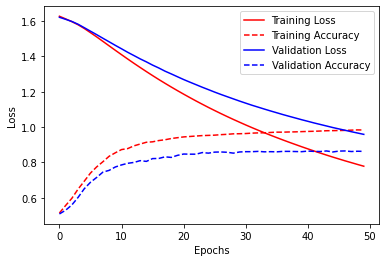

In [10]:
# Plot validation performance. 
plt.plot(average_loss_history,c='r')
plt.plot(average_acc_history,c="r",linestyle="dashed")
plt.plot(average_val_loss_history,c='b')
plt.plot(average_val_acc_history,c='b',linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Training Loss','Training Accuracy','Validation Loss','Validation Accuracy'])
plt.show()